In [2]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

#####################################################
# This is almost identical to simple demonstration 
# -- except covariates have a skewed covariance matrix
#
# In this notebook, we train a 3-layer linear transformer with
# - context-length 20
# - covariate dimension 5, standard Gaussian distribution
# We plot
# - test loss against number of iterations
# - imshow of each parameter matrix at end of training
# - distance-to-identity of each parameter matrix
#####################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log' 
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/rotation.log', "a", 1)
#sys.stdout = f

In [39]:
# Set up problem parameters

lr = 0.1
clip_r = 1
alg = 'lbfgs'
mode = 'normal'
max_iters = 2000  # Number of Iterations to run
hist_stride = 10  # stride for saved model paramters in `train.ipynb'
stride = 10


n_layer = 3  # number of layers of transformer
N = 20     # context length
d = 5        # dimension

n_head = 1  # 1-headed attention
B = 20000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates

In [46]:
filename_format = '/rotation_hist_lbfgs_{}_{}_{}.pth'
filename = filename_format.format(n_layer, N, d)
filename = (cur_dir + filename)
hist_dict = {}
U_dict = {}
D_dict = {}

seeds = [0,1,2] #for demonstration purpose, just use 3 seeds
keys = [(s,) for s in seeds]
for key in keys:
    sd = key[0]
    
    prob_seed = sd
    opt_seed = sd
    
    hist_dict[key] = []
    
    #set seed and initialize model
    torch.manual_seed(opt_seed)
    
    model = Transformer_F(n_layer, 1, d, var)
    model.to(device)
    #initialize algorithm. Important: set beta = 0.9 for adam, 0.999 is very slow
    optimizer = torch.optim.LBFGS(model.parameters(), history_size=600, max_iter=4, lr = lr)
    
    # set seed
    # sample random rotation matrix
    # initialize initial training batch
    np.random.seed(prob_seed)
    torch.manual_seed(prob_seed)
    gaus = torch.FloatTensor(5,5).uniform_(-1,1).cuda()
    U = torch.linalg.svd (gaus)[0].cuda()
    D = torch.diag(torch.FloatTensor([1,1,1/2,1/4,1])).cuda()
    U_dict[key]=U
    D_dict[key]=D
    
    #  generate a SINGLE BATCH of training set USED FOREVER
    Z, y = generate_data(mode,N,d,B,shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)
    
    for t in range(max_iters):
        start = time.time()
        # save model parameters
        if t%stride ==0:
            hist_dict[key].append(model.allparam.clone().detach())
        
        
        def closure():
            optimizer.zero_grad()
            loss = in_context_loss(model, Z, y)
            loss.backward()
            return loss
        loss = in_context_loss(model, Z, y)
        loss.backward()
        norms = model.allparam.grad.norm()
        optimizer.step(closure)
        optimizer.zero_grad()

        end=time.time()
        if t%100 ==0 or t<5:
            print('iter {} | Loss: {}  time: {}  gradnorm: {}'.format(t,loss.item(), end-start, norms))
    #save to 
torch.save({'hist_dict':hist_dict, 'U_dict':U_dict, 'D_dict':D_dict}, filename)

iter 0 | Loss: 4.944925785064697  time: 0.09100484848022461  gradnorm: 5.96251916885376
iter 1 | Loss: 4.103914260864258  time: 0.07890534400939941  gradnorm: 4.290714740753174
iter 2 | Loss: 3.294581174850464  time: 0.07899212837219238  gradnorm: 2.8401200771331787
iter 3 | Loss: 2.6232664585113525  time: 0.07909488677978516  gradnorm: 1.8251594305038452
iter 4 | Loss: 2.0743260383605957  time: 0.06609344482421875  gradnorm: 1.1291693449020386
iter 100 | Loss: 0.00621597608551383  time: 0.15596628189086914  gradnorm: 0.00364688434638083
iter 200 | Loss: 0.0016783452592790127  time: 0.20432710647583008  gradnorm: 0.0018044934840872884
iter 300 | Loss: 0.0012125845532864332  time: 0.21982622146606445  gradnorm: 0.00017991293861996382
iter 400 | Loss: 0.0007418777677230537  time: 0.20566129684448242  gradnorm: 0.0001594391360413283
iter 500 | Loss: 0.0006358986138366163  time: 0.20577430725097656  gradnorm: 6.198487244546413e-05
iter 600 | Loss: 0.0006253551109693944  time: 0.20913195610

In [47]:
####################################
# compute test loss
####################################
#hist_dict = torch.load(filename)['hist_dict']
loss_dict = {}
for key in hist_dict:
    sd = key[0]
    
    U = U_dict[key]
    D = D_dict[key]
    
    loss_dict[key] = torch.zeros(max_iters//stride)
    
    np.random.seed(99)
    torch.manual_seed(99)
    Z, y = generate_data(mode,N,d,B,shape_k,U,D)
    Z = Z.to(device)
    y = y.to(device)
    model = Transformer_F(n_layer, n_head, d, var).to(device)
    for t in range(0,max_iters,stride):
        with torch.no_grad():
            model.allparam.copy_(hist_dict[key][t//stride])
        loss_dict[key][t//stride] = in_context_loss(model, Z, y).item()

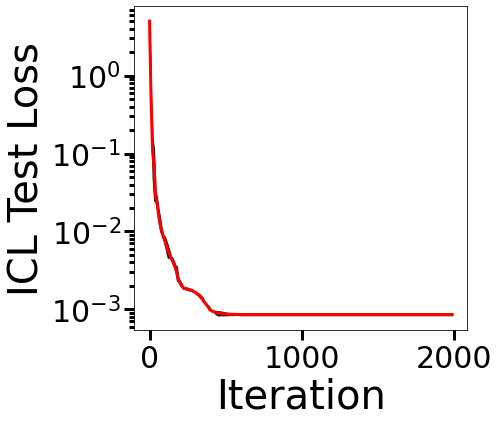

In [51]:
####################################
# plot the test loss with error bars
####################################

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (7, 6))

losses = torch.zeros(len(seeds), max_iters//stride)
keys = loss_dict.keys()
for idx, key in enumerate(keys):
    losses[idx,:] = loss_dict[key]
losses_mean = torch.mean(losses, axis=0)
losses_std = torch.std(losses, axis=0)
ax.plot(range(0,max_iters,stride), losses_mean, color = 'red', lw = 3)#, label='Adam')
ax.fill_between(range(0,max_iters,stride), losses_mean-losses_std, losses_mean+losses_std, color = 'black', alpha = 0.2)
ax.set_xlabel('Iteration',fontsize=40)
ax.set_ylabel('ICL Test Loss',fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
#ax.legend(fontsize=30)
ax.set_yscale('log')


plt.tight_layout()
plt.savefig(fig_dir + '/rotation_demonstration_loss_plot.pdf', dpi=600)

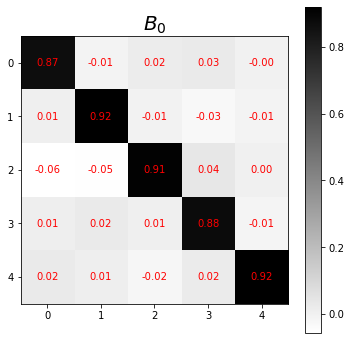

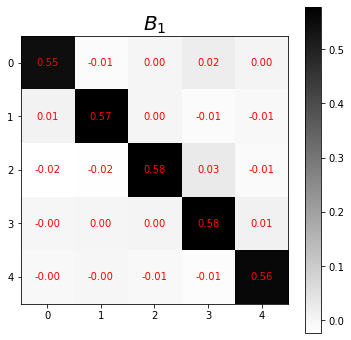

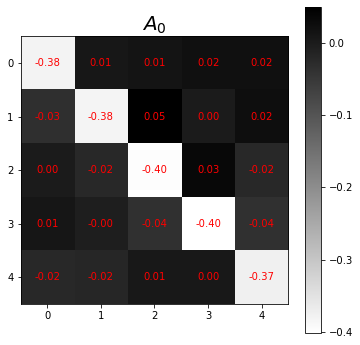

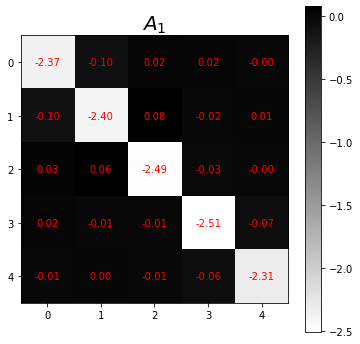

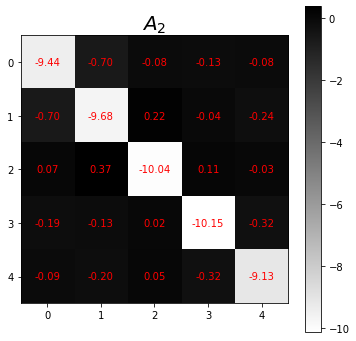

In [52]:
####################################
# display the parameter matrices
# image/font setting assumes d=5
####################################

key = (0,)
for l in range(n_layer-1):
    for h in range(n_head):
        fig, ax = plt.subplots(1, 1,figsize = (6, 6))
        matrix = hist_dict[key][-1][l,h,0,:,:]
        # Create a heatmap using imshow
        im = ax.imshow(matrix.cpu(), cmap='gray_r')
        # Add the matrix values as text
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(j, i, format(matrix[i, j], '.2f'), ha='center', va='center', color='r')
        # Add a colorbar for reference
        fig.colorbar(im)
        ax.set_title('$B_{}$'.format(l),fontsize=20)
        
        plt.savefig(fig_dir + '/rotation_demonstration_B{}.pdf'.format(l), dpi=600)

U = U_dict[(0,)]
D = D_dict[(0,)]
UD = torch.mm(U,D)        
for l in range(n_layer):
    for h in range(n_head):
        fig, ax = plt.subplots(1, 1,figsize = (6, 6))
        matrix = hist_dict[key][-1][l,h,1,:,:]
        #rotate matrix by inverse of UD
        matrix = torch.mm(torch.mm(UD.t(), matrix), UD)
        # Create a heatmap using imshow
        im = ax.imshow(matrix.cpu(), cmap='gray_r')
        # Add the matrix values as text
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(j, i, format(matrix[i, j], '.2f'), ha='center', va='center', color='r')
        # Add a colorbar for reference
        fig.colorbar(im)
        ax.set_title('$A_{}$'.format(l),fontsize=20)
        plt.savefig(fig_dir + '/rotation_demonstration_A{}.pdf'.format(l), dpi=600)
    

In [54]:
########################################################
# plot the distance-to-identity of each matrix with time
########################################################

# function for computing distance to identity
def compute_dist_identity(M):
    scale = torch.sum(torch.diagonal(M))/M.shape[0]
    ideal_identity = scale* torch.eye(M.shape[0]).to(device)
    difference = M - ideal_identity
    err = (torch.norm(difference,p='fro')/torch.norm(M,p='fro')).item()
    return err

########################################
# compute distances (assume n_head = 1)
########################################
dist_dict = {}
            
for key in hist_dict:
    (sd,) = key
    dist_dict[key] = torch.zeros(n_layer, 2, max_iters//stride)
    U = U_dict[key]
    D = D_dict[key]
    UD = torch.mm(U,D)        
    for t in range(0,max_iters,stride):
        with torch.no_grad():
            allparam = hist_dict[key][t//stride]
        for i in range(n_layer):
            for j in range(2):
                matrix = allparam[i,0,j,:,:]
                if j ==1:
                    matrix = torch.mm(torch.mm(UD.t(), matrix), UD)
                dist_dict[key][i,j,t//stride] = compute_dist_identity(matrix)

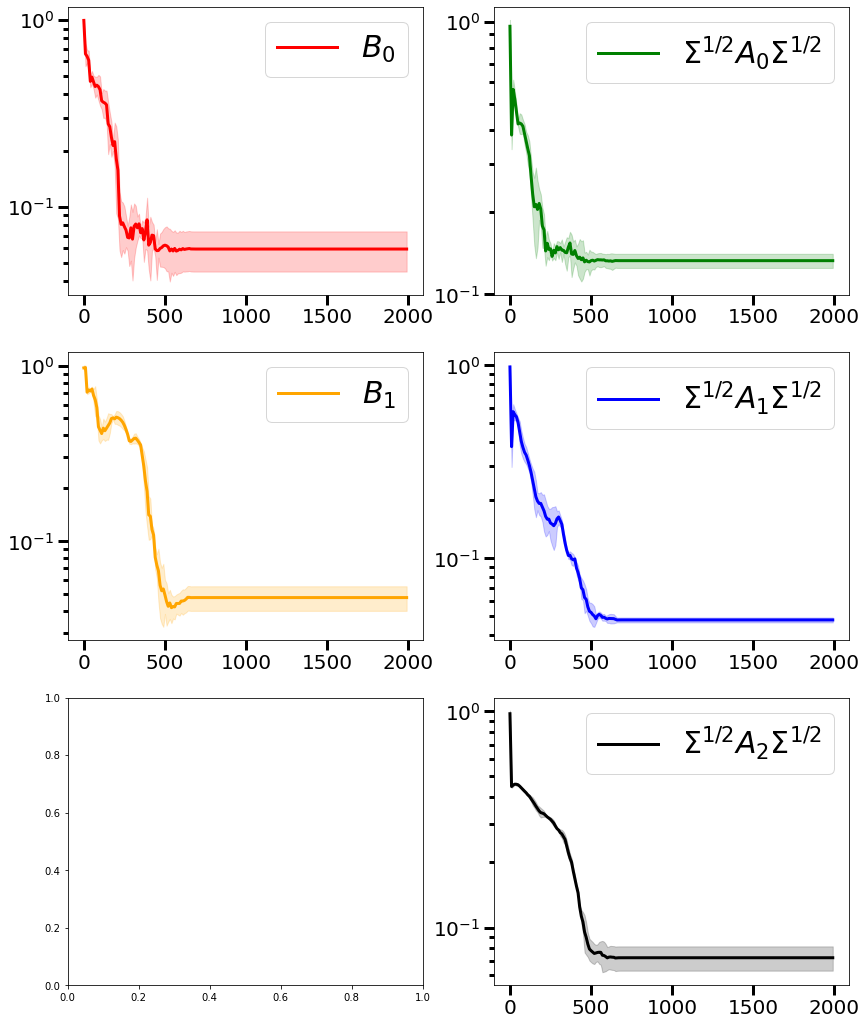

In [58]:

####################################
# plot distances
####################################

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, axs = plt.subplots(3, 2,figsize = (14, 18))

labels = ['$B_0$', '$B_1$', None, 
          '$\Sigma^{1/2} A_0 \Sigma^{1/2}$', 
          '$\Sigma^{1/2} A_1 \Sigma^{1/2}$', 
          '$\Sigma^{1/2} A_2 \Sigma^{1/2}$']
colors = ['red','orange',None, 'green','blue','black']

#make P plots
for l in range(n_layer):
    for pq in range(2):
        if l==n_layer-1 and pq==0:
            continue
        ax = axs[l,pq]
        dist_p = torch.zeros(len(seeds), max_iters//stride)
        for idx, sd in enumerate(seeds):
            losses[idx,:] = dist_dict[(sd,)][l,pq,:]
        dist_mean = torch.mean(losses, axis=0)
        dist_std = torch.std(losses, axis=0)
        
        style_id = l + 3*pq
        
        ax.plot(range(0,max_iters,stride), dist_mean, color = colors[style_id], lw = 3, label=labels[style_id])
        ax.fill_between(range(0,max_iters,stride), dist_mean-dist_std, dist_mean+dist_std, color = colors[style_id], alpha = 0.2)
        #ax.set_xlabel('Iteration',fontsize=40)
        ax.tick_params(axis='both', which='major', labelsize=20, width = 3, length = 10)
        ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
        ax.legend(fontsize=30)
        ax.set_ylim([0,1])
        
plt.savefig(fig_dir + '/rotation_demonstration_dist_to_id_lbfgs.pdf', dpi=600)



In [9]:
print((hist_dict[(0,)][100]- hist_dict[(1,)][100]).norm())
print((compute_dist_identity(hist_dict[(0,)][100][i,0,j,:,:]) - compute_dist_identity(hist_dict[(1,)][100][i,0,j,:,:])))
print((dist_dict[(0,)][0,0,10]- dist_dict[(1,)][0,0,10]).norm())


tensor(0.45, device='cuda:0')
0.029331311583518982
tensor(0.00)


In [38]:
print(len(hist_dict[key]))

200
